In [1]:
# Import libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.svm as svm
import sklearn.pipeline as spl
import sklearn.kernel_ridge as skr
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.neighbors as snn
import sklearn.metrics as sme
import sklearn.decomposition as sdc
import sklearn.cross_decomposition as skd
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
from sklearn.utils import resample
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util
from lao_net import Net, train_model
from sklearn import metrics
import nibabel as nib
import gc
import torch
patch_sklearn()
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
#     Performed poorly using Standard and MinMax scalers. Trying with LOOCV to see if predictions stabilize.
#     Does not appear to stabilize predictions with LOOCV (using StandardScaler())
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function?
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# CHECK PHI AND X DIRECTORIES, WHICH ONE IS RIGHT?

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528_wldd.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','pre op levadopa equivalent dose (mg)','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off,ledd = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo',
                                                          'pre op levadopa equivalent dose (mg)')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)
del Phi_all, X_all, R_all, K_all
ids = np.asarray(ID_all).astype(int)

# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subs_init = subs[s_cases_idx]
pre_imp_init = pre_imp[s_cases_idx]
post_imp_init = post_imp[s_cases_idx]
pre_updrs_off_init = pre_updrs_off[s_cases_idx]
per_change_init = post_imp_init
subs = np.asarray(ID_all,dtype=float)[np.in1d(np.asarray(ID_all,dtype=float),subs_init)]

pre_imp = np.zeros((1,len(subs))).T
post_imp = np.zeros((1,len(subs))).T
pre_updrs_off = np.zeros((1,len(subs))).T
per_change = np.zeros((1,len(subs))).T
for j in np.arange(len(subs)):
    pre_imp[j] = pre_imp_init[subs_init == subs[j]]
    post_imp[j] = post_imp_init[subs_init == subs[j]]
    pre_updrs_off[j] = pre_updrs_off_init[subs_init == subs[j]]
    per_change[j] = per_change_init[subs_init == subs[j]]

       Unnamed: 0                PRE-OP           Unnamed: 2  \
0      CORNELL ID  Apathy Off (pre-dbs)  Apathy ON (pre-dbs)   
1              67                    na                   13   
2   only Ct data                     na                   na   
3              74                    na                   na   
4              84                    na                   22   
..            ...                   ...                  ...   
87             52                   NaN                  NaN   
88             53                   NaN                  NaN   
89             54                   NaN                  NaN   
90             55                   NaN                  NaN   
91             56                   NaN                  NaN   

             Unnamed: 3          Unnamed: 4    Unnamed: 5  \
0   OFF (pre-dbs updrs)  ON (pre-dbs updrs)  mri (pre-op)   
1                    60                  41      3/9/2020   
2                    43                  12     

In [5]:
subsc = subs_init
X_img = []


In [6]:
gc.collect()

416

In [7]:
reload = 0
if reload == 1:
    qsms = util.full_path('/home/ali/RadDBS-QSM/data/nii/qsm')
    qsms_subs = []
    for Q in np.arange(len(qsms)):
        qsms_subs.append(int(qsms[Q][-9:-7]))

    for j in np.arange(len(subs_init)):
        q = np.where(qsms_subs==subs_init[j])[0][0]
        data = nib.load(qsms[q])
        try:
            if qsms_subs[q] < 10:
                mask = nib.load('/home/ali/RadDBS-QSM/data/nii/seg/labels_2iMag0'+str(qsms_subs[q])+'.nii.gz').get_fdata()
            else:
                mask = nib.load('/home/ali/RadDBS-QSM/data/nii/seg/labels_2iMag'+str(qsms_subs[q])+'.nii.gz').get_fdata()
            mask[mask > 4] = 0
            mask[mask < 3] = 0
            maskc = util.pad_to(util.mask_crop(mask,mask),64,64,64)
            data = util.pad_to(util.mask_crop(mask*data.get_fdata(),mask),64,64,64)
            mask_k = []
            k_all = []
            for k in np.arange(maskc.shape[2]):
                    if np.sum(maskc[:,:,k]) > 0:
                        mask_k.append(np.sum(maskc[:,:,k]))
                        k_all.append(k)
                
            img = data[:,:,k_all[np.argmax(mask_k)]]
            # img[img<-250] = -250
            # img[img>250] = 250
            X_img.append(torch.Tensor(img).cuda())
            print('Maximum volume found at slice',str(k_all[np.argmax(mask_k)]),'for case',str(qsms_subs[q]))
            plt.imshow(img)
            plt.show()
        except:
            print('Missing mask at',str(qsms_subs[q]))
            subsc = np.delete(subsc,j)
            per_change = np.delete(per_change,j)
            pre_imp = np.delete(pre_imp,j)
            pre_updrs_off = np.delete(pre_updrs_off,j)
    torch.save(X_img,'X_img.pt') 
else:
    X_img = torch.load('X_img.pt')
    subsc = subsc[:-1]
    per_change = per_change[:-1]
    pre_imp = pre_imp[:-1]
    pre_updrs_off = np.squeeze(pre_updrs_off[:-1])


In [8]:
gc.collect()

30

In [9]:
X_img = torch.stack(X_img).detach().cpu().numpy()
results_bls = np.zeros_like(per_change)

In [10]:
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_test = X_img[test_index,:,:]
    X_train = X_img[train_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]
    # Cross validation
    cvn = 4
    # ADD PRE-UPDRS as a residual connection to the last linear layer
    # MLP
    encoder = Net(in_size=X_train.shape[-1],n_channels=4)
    yt, encoder, _ = train_model(X_all=X_train,
                     y_all=y_train,
                     u_all = pre_updrs_off[train_index],
                     model=encoder,
                     X_test=X_test,
                     u_test = pre_updrs_off[test_index],
                     warm_start_weights=[],
                     early_stopping=[],
                     tol=1e-6,
                     lr=1e-3,
                     lr_decay=None,
                     alpha=1e-2,
                     reg_type='l2',
                     thresh=[],
                     num_epochs=int(200),
                     batch_size=len(X_img)-1,
                     case_id=str(int(subsc[j])),
                     num_neighbors=0,
                     random_val=True,
                     verbose=2,
                     save_state=False)

    results_bls[j] = yt.detach().cpu().numpy()
    print('MLP predicts',str(np.round(yt.item(),3)),
            'for case',str(int(subsc[j])),'with',str(np.round(per_change[j],2)))

Using constant kernel and channel sizes
Creating 1 batchs of size 45 from 45 training cases
Model contains 272145082 trainable parameters
Net(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=11664, out_features=11664, bias=True)
  (fc2): Linear(in_features=11664, out_features=11664, bias=True)
  (r): Linear(in_features=23329, out_features=1, bias=True)
)
Best training loss: 0.1566801518201828 at learning rate 0.001 and epoch 0
Train Epoch: 0 [1/1 (0%)]	Loss: 0.156680
0.001
Best training loss: 0.028574472293257713 a

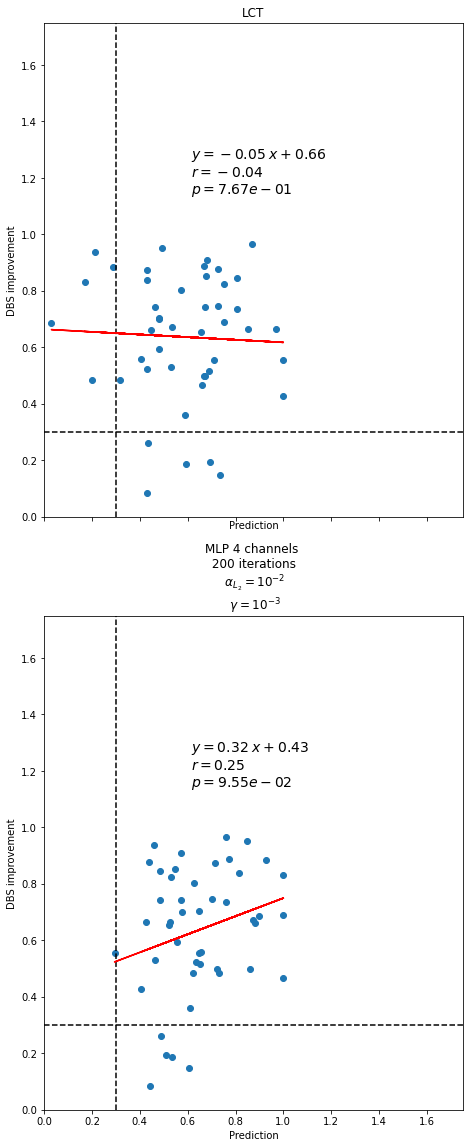

In [11]:
results_bls[results_bls>1] = 1
util.eval_prediction(np.vstack((pre_imp.T,
                               results_bls.T,
                               )),
                               per_change.T,
                               ['LCT',
                                'MLP 4 channels \n 200 iterations \n $\\alpha_{L_2} = 10^{-2}$ \n $\gamma=10^{-3}$',
                                ],(15,10))
plt.ylim([0,1.75])
plt.xlim([0,1.75])
plt.style.use('default')